In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import re
import nltk
import string
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score

In [2]:
def load_data(test, spam):
    
    #Read emails from 2 csv files; one for emails from inbox and the other for spam
    #In the 2 csv files, column 'v1' is label of the email and 'v2' is the body of the email
    df1 = pd.read_csv('INBOX.csv', encoding = 'utf-8')
    df2 = pd.read_csv('SPAM.csv', encoding = 'utf-8')
    
    #Concatenate and shuffle emails
    frames = [df1, df2]
    df = pd.concat(frames)
    df = df.sample(frac = 1).reset_index(drop = True)
    
    return(df)

In [3]:
def data_clean(df):
    
    #Remove byte flag and quotations marks
    df['v2'] = df['v2'].str[2:]
    df['v2'] = df['v2'].str[:-1]
    
    #Remove irrelevant punctuations
    df['v2'] = df['v2'].str.replace('[{}]'.format(string.punctuation), '')
    
    #Convert email body to lowercase for easy processing of data
    df['v2'] = df['v2'].str.lower()
    
    #Remove numbers
    df['v2'] = df['v2'].str.replace('^\d+\s|\s\d+\s|\s\d+$', '', regex = True)
    
    #Remove URLs
    df['v2'] = df['v2'].str.replace('http\S+|www.\S+', '', regex = True)
    
    #Remove email addresses
    df['v2'] = df['v2'].str.replace(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+', '', regex = True)
    
    return(df)

In [4]:
def stop_words(df):
    
    #Store common stopwords into a variable
    stop = stopwords.words('english')
    
    #Remove stop words from email body
    df['v2'] = df['v2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return(df)

In [5]:
def lemmatize_text(text):
    
    #Lemmatize the email body
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [1]:
def my_train_test_split(df):
    
    # Create test and train datasets with test size of 30%
    x_train, x_test, y_train, y_test = train_test_split(df.v2, df.v1, test_size = 0.3, random_state = 100)
    
    return(x_train, x_test, y_train, y_test)

In [7]:
def build_dictionary(x_train):

    list_of_words = []

    #Store words from emails into a list
    for index, line in x_train.iteritems():
        words = line.split()
        list_of_words += words
    
    #Remove non alphabets and single character text
    for index, word in enumerate(list_of_words):
        if word.isalpha() == False or len(word) < 2:
            del list_of_words[index]

    #Create dictionary with key as unique words and value as their number of occurrences in emails
    dictionary = Counter(list_of_words)
    
    #Remove unique words with 1 count
    dictionary = {k : v for k, v in dictionary.items() if v != 1}
    
    return(dictionary)

In [8]:
def build_features(x_train, dictionary):
    
    #Store features in ndarray
    feature_matrix = np.zeros((x_train.shape[0], len(dictionary)))

    #Store the number of occurances of each word in the emails
    for index, line in x_train.iteritems():
        words = line.split()
        for word_index, word in enumerate(dictionary):
            feature_matrix[index, word_index] = words.count(word)
    
    return(feature_matrix)

In [9]:
def roc_curve_plot(classifier, X_test, y_test):
    
    #Predict probabilities of occurrences
    probabality = classifier.predict_proba(X_test)
    prediction = probabality[:, 1]
    
    #Label classes
    y_test_labeled = label_binarize(y_test, classes = ['spam', 'ham'])
    
    #Retrieve False Positive and True Positive values
    fpr, tpr, threshold = metrics.roc_curve(y_test_labeled, prediction, pos_label = 0)
    
    #Plot ROC curve
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
#Load email from inbox and spam labels
df = load_data('INBOX.csv', 'SPAM.csv')

# Clean data
df = data_clean(df)
df = stop_words(df)
words = set(nltk.corpus.words.words())
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
df['v2'] = df.v2.apply(lemmatize_text)

In [11]:
#Split into train and test datasets
x_train, x_test, y_train, y_test = my_train_test_split(df)

In [12]:
#Reindex train and test datasets
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [13]:
#Build dictionary for unique words from dataset
dictionary = build_dictionary(x_train)

In [14]:
#Create train and test feature sets
train_feature_matrix = build_features(x_train, dictionary)
test_feature_matrix = build_features(x_test, dictionary)

C:\Users\prani\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


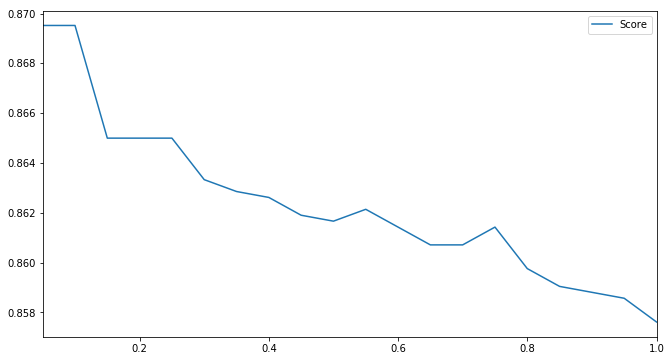

In [15]:
#Multinomial Naive Bayes and Hyperparameter Tuning
pred_scores = []

for i in np.linspace(0.05, 1, num=20):
    mnb = MultinomialNB(alpha = i)
    mnb.fit(train_feature_matrix, y_train)
    pred = mnb.predict(test_feature_matrix)
    pred_scores.append((i, [accuracy_score(y_test, pred)]))
    
df_scores = pd.DataFrame.from_items(pred_scores, orient = 'index', columns = ['Score'])
df_scores.plot(figsize = (11, 6))

In [16]:
df_scores[df_scores['Score'] == df_scores['Score'].max()]

,Score
0.05,0.869524
0.10,0.869524


In [17]:
i_value = df_scores[df_scores['Score'] == df_scores['Score'].max()].index.values.astype(float)[0]

Confusion Matrix of Naive Bayes Algorithm is
[[1850  276]
 [ 272 1802]]
Precision of Naive Bayes Algorithm is 0.8694995096967559
Recall of Naive Bayes Algorithm is 0.8695155992165693
Accuracy of Naive Bayes Algorithm is 0.8695238095238095


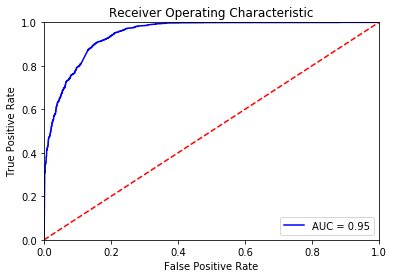

In [18]:
# Multinomial Naive Bayes Performance
classifier_MNB = MultinomialNB(alpha = i_value)
classifier_MNB.fit(train_feature_matrix, y_train)
result_MNB = classifier_MNB.predict(test_feature_matrix)

print('Confusion Matrix of Naive Bayes Algorithm is\n{0}'.format(confusion_matrix(y_test, result_MNB)))
print('Precision of Naive Bayes Algorithm is {0}'.format(precision_score(y_test, result_MNB, average="macro")))
print('Recall of Naive Bayes Algorithm is {0}'.format(recall_score(y_test, result_MNB, average="macro")))
print('Accuracy of Naive Bayes Algorithm is {0}'.format(classifier_MNB.score(test_feature_matrix, y_test)))

roc_curve_plot(classifier_MNB, test_feature_matrix, y_test)

C:\Users\prani\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


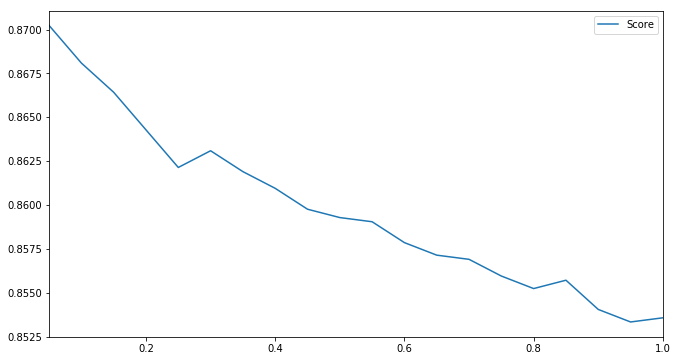

In [19]:
# Bernoulli's Naive Bayes and Hyperparameter Tuning
pred_scores = []

for i in np.linspace(0.05, 1, num = 20):
    mnb = BernoulliNB(alpha = i)
    mnb.fit(train_feature_matrix, y_train)
    pred = mnb.predict(test_feature_matrix)
    pred_scores.append((i, [accuracy_score(y_test, pred)]))
    
df_scores = pd.DataFrame.from_items(pred_scores, orient = 'index', columns = ['Score'])
df_scores.plot(figsize = (11,6))

In [20]:
df_scores[df_scores['Score'] == df_scores['Score'].max()]

,Score
0.05,0.870238


In [21]:
i_value = df_scores[df_scores['Score'] == df_scores['Score'].max()].index.values.astype(float)[0]

Confusion Matrix of Bernoulli's Naive Bayes Algorithm is
[[1846  280]
 [ 265 1809]]
Precision of Bernoulli's Naive Bayes Algorithm is 0.870215826783456
Recall of Bernoulli's Naive Bayes Algorithm is 0.8702624257142364
Accuracy of Bernoulli's Naive Bayes Algorithm is 0.8702380952380953


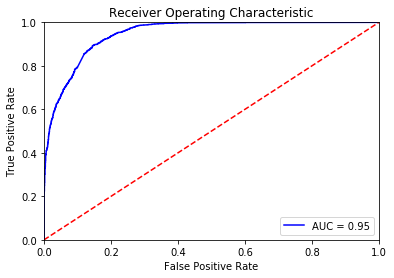

In [22]:
# Bernoulli's Naive Bayes Performance
classifier_BNB = BernoulliNB(alpha = i_value)
classifier_BNB.fit(train_feature_matrix, y_train)
result_BNB = classifier_BNB.predict(test_feature_matrix)

print('Confusion Matrix of Bernoulli\'s Naive Bayes Algorithm is\n{0}'.format(confusion_matrix(y_test, result_BNB)))
print('Precision of Bernoulli\'s Naive Bayes Algorithm is {0}'.format(precision_score(y_test, result_BNB, average="macro")))
print('Recall of Bernoulli\'s Naive Bayes Algorithm is {0}'.format(recall_score(y_test, result_BNB, average="macro")))
print('Accuracy of Bernoulli\'s Naive Bayes Algorithm is {0}'.format(classifier_BNB.score(test_feature_matrix, y_test)))

roc_curve_plot(classifier_BNB, test_feature_matrix, y_test)

C:\Users\prani\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\prani\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':


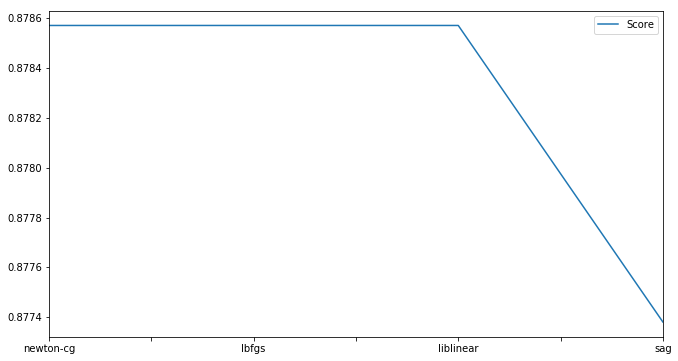

In [23]:
# Logistic Regression and Hyperparameter Tuning
slvr = {'newton-cg' : 'newton-cg', 'lbfgs': 'lbfgs', 'liblinear': 'liblinear', 'sag': 'sag'}
pred_scores = []

for k, v in slvr.items():
    lrc = LogisticRegression(solver = v, penalty = 'l2')
    lrc.fit(train_feature_matrix, y_train)
    pred = lrc.predict(test_feature_matrix)
    pred_scores.append((k, [accuracy_score(y_test, pred)]))
    
df_scores = pd.DataFrame.from_items(pred_scores, orient = 'index', columns = ['Score'])
df_scores.plot(figsize = (11,6))

In [24]:
df_scores[df_scores['Score'] == df_scores['Score'].max()]

,Score
newton-cg,0.878571
lbfgs,0.878571
liblinear,0.878571


In [25]:
solver_value = df_scores[df_scores['Score'] == df_scores['Score'].max()].index.values.astype(str)[0]

In [26]:
solver_value = str(solver_value)

Confusion Matrix of Logistic Regression Algorithm is
[[1777  349]
 [ 161 1913]]
Precision of Logistic Regression Algorithm is 0.881318212053773
Recall of Logistic Regression Algorithm is 0.8791070921529014
Accuracy of Logistic Regression Algorithm is 0.8785714285714286


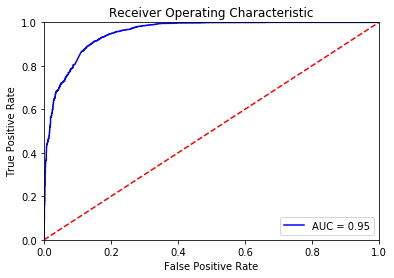

In [27]:
# Logistic Regression Performance
classifier_LR = LogisticRegression(solver = solver_value, penalty = 'l2')
classifier_LR.fit(train_feature_matrix, y_train)
result_LR = classifier_LR.predict(test_feature_matrix)

print('Confusion Matrix of Logistic Regression Algorithm is\n{0}'.format(confusion_matrix(y_test, result_LR)))
print('Precision of Logistic Regression Algorithm is {0}'.format(precision_score(y_test, result_LR, average="macro")))
print('Recall of Logistic Regression Algorithm is {0}'.format(recall_score(y_test, result_LR, average="macro")))
print('Accuracy of Logistic Regression Algorithm is {0}'.format(classifier_LR.score(test_feature_matrix, y_test)))

roc_curve_plot(classifier_LR, test_feature_matrix, y_test)